In [3]:
from covid.simulator import Population
from covid.auxilliary import symptom_names
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid.policy import Policy
from scipy.stats import beta, bernoulli, uniform

In [4]:
np.random.laplace(0,0.1)

-0.0331664748371159

In [5]:
class ThompsonSampling:
    def __init__(self, nvacc):
        # Priors for the beta-bernoulli model
        self.a = np.ones(nvacc) # uniform prior
        self.b = np.ones(nvacc) # uniform prior
        self.nvacc = nvacc

    def update(self, action, outcome):
        self.a[action] += outcome
        self.b[action] += 1 - outcome
    
    def update_with_laplace(self, action, outcome):
        outcome = outcome + np.random.laplace(0, 0.1)
        self.a[action] += outcome
        self.b[action] += 1 - outcome
    
    def get_params(self):
        # Returns the parameters of all the beta distrobutions.
        return self.a, self.b

    def get_prob(self):
        return beta.rvs(self.a, self.b)

In [6]:
class Naive(Policy):
    def set_model(self, model):
        self.model = model
    
    def get_action(self):
        probs = self.model.get_prob()
        
        #print(probs)
        ret_val = np.argmin(probs)
        #print(ret_val)
        #print(ret_val)
        return ret_val

    def observe(self, action, outcome):
        self.model.update(action, outcome)
        
    def observe_with_laplace(self, action, outcome):
        self.model.update_with_laplace(action, outcome)


In [95]:
class NaiveForExample(Policy):
    def set_model(self, model):
        self.model = model
    
    def get_action(self):
        probs = self.model.get_prob()
        
        #print(probs)
        ret_val = np.argmax(probs)
        #print(ret_val)
        #print(ret_val)
        return ret_val

    def observe(self, action, outcome):
        self.model.update(action, outcome)
        
    def observe_with_laplace(self, action, outcome):
        self.model.update_with_laplace(action, outcome)
        

In [101]:
thetas = np.array([0.8, 0.75, 0.85])

In [102]:
n_genes = 128
n_vaccines = 3
n_treatment = 4
#population = Population(n_genes, n_vaccines, n_treatment)
N = 10000
#X = population.generate(N)

In [103]:
policy = NaiveForExample(n_actions=3, action_set=[0, 1, 2])
model = ThompsonSampling(nvacc=3)
policy.set_model(model)

action_arr = np.zeros(N)
symptom_arr = np.zeros(N)

for i in range(N):
    action = policy.get_action()
    #print(thetas[action])
    reward = bernoulli.rvs(thetas[action])
    #print(reward)
    policy.observe(action, reward)
    action_arr[i] = action
    symptom_arr[i] = reward

    #print(action, reward)
    #policy.observe(action, reward)
    #print(action)

alphas, betas = policy.model.get_params()
for i, j in zip(alphas, betas):
    print(i,j)
print(alphas[0]/(alphas[0] + betas[0]))
print(alphas[1]/(alphas[1] + betas[1]))
print(alphas[2]/(alphas[2] + betas[2]))


Initialising policy with  3 actions
A = { [0, 1, 2] }
424.0 103.0
83.0 32.0
7937.0 1427.0
0.8045540796963947
0.7217391304347827
0.8476078598889364


In [108]:
#print(action_arr)
#plt.scatter(range(N), action_arr)
def plot_action_known_theta(actions):
    plt.hist(actions)
    plt.xlabel('Bandit')
    plt.ylabel('Frequency')
    plt.title('Banidts played known probability')
    #plt.legend(loc='upper right')
    plt.savefig('figures/banidts_played_known_prob_hist.png')
    plt.show()

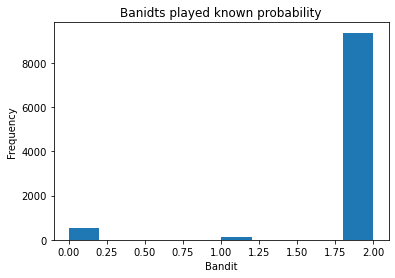

In [109]:
plot_action_known_theta(action_arr)

In [114]:
def plot_bandits_played_time(actions, N):
    plt.scatter(range(N), actions, s=1)
    plt.ylabel('Bandit played')
    plt.xlabel('Simulation time')
    plt.title('Banidts played known probability over time')
    #plt.legend(loc='upper right')
    plt.savefig('figures/banidts_played_known_prob_over_time.png')
    plt.show()

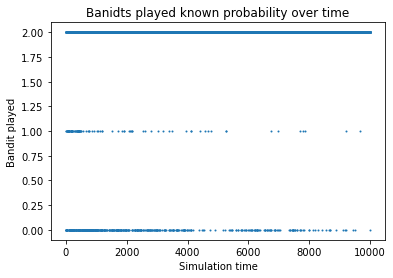

In [115]:
plot_bandits_played_time(action_arr, N)

In [12]:
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_000
n_symptoms = 10

# symptom names for easy reference
from covid.auxilliary import symptom_names

np.random.seed(1)

population = Population(n_genes, n_vaccines, n_treatments)
X = population.generate(n_population)
n_features = X.shape[1]

In [13]:
#new_col = X[:,[5,7,8]].sum(axis=1)
#new_col0 = new_col > 0
#new_col01 = new_col0.astype(int)
#new_col01 = np.reshape(new_col01,(n_population,-1))
#X_new = np.hstack((X,new_col01))



In [14]:
action_space = np.array([-1,0,1,2])
n_actions = action_space.shape[0]

In [15]:
policy = Naive(n_actions, action_space)
model = ThompsonSampling(n_actions)
policy.set_model(model)



Initialising policy with  4 actions
A = { [-1  0  1  2] }


In [16]:
action_arr = np.zeros(n_population)
symptom_arr = np.zeros((n_population, n_symptoms+1))
symptom_arr.shape

(10000, 11)

In [17]:
print("With a for loop")
# The simplest way to work is to go through every individual in the population
for t in range(n_population):
    a_t = policy.get_action()
    #print(type(a_t))
    #a_t = np.int(3)
    # Then you can obtain results for everybody
    y_t = population.vaccinate([t], a_t.reshape((1, 1)))
    #print(y_t.shape)
    new_col = y_t[:,[5,7,8]].sum(axis=1)
    
    #print(y_t)
    new_col0 = new_col > 0
    new_col01 = new_col0.astype(int)
    
    #new_col01 = np.reshape(new_col01,(n_population,-1))
    
    new_col01 = np.reshape(new_col01,(1,-1))
    y_t_new = np.hstack((y_t,new_col01))
    
    # Feed the results back in your policy. This allows you to fit the
    # statistical model you have.
    #print( y_t_new[:,10])
    
    policy.observe(a_t, y_t_new[:,10])
    #policy.observe(a_t, y_t_new[:,1])
    
    action_arr[t] = a_t
    symptom_arr[t] = y_t_new


With a for loop


In [18]:
print(action_arr)

[3. 3. 3. ... 1. 0. 1.]


In [19]:
alphas, betas = policy.model.get_params()
for i, j in zip(alphas, betas):
    print(i,j)
print(alphas[0]/(alphas[0] + betas[0]))
print(alphas[1]/(alphas[1] + betas[1]))
print(alphas[2]/(alphas[2] + betas[2]))
print(alphas[3]/(alphas[3] + betas[3]))

58.0 1579.0
126.0 3676.0
18.0 364.0
146.0 4041.0
0.0354306658521686
0.03314045239347712
0.04712041884816754
0.03486983520420349


In [20]:
utility_normal = -sum(alphas)
utility_normal

-348.0

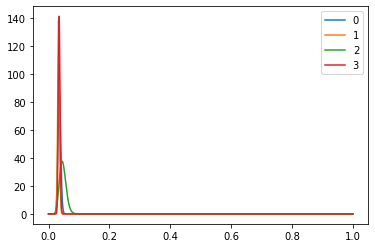

In [21]:
xs = np.linspace(0, 1, 10000)
plt.plot(xs, beta.pdf(xs, alphas[0], betas[0]))
plt.plot(xs, beta.pdf(xs, alphas[1], betas[1]))
plt.plot(xs, beta.pdf(xs, alphas[2], betas[2]))
plt.plot(xs, beta.pdf(xs, alphas[3], betas[3]))
plt.legend(['0', '1', '2', '3'])

#


In [88]:
def plot_thompson_pol(actions):
    #plt.hist(action_arr)
    plt.hist(actions)#, label=['0','1','2','3'])
    plt.xlabel('Vaccine')
    plt.ylabel('Frequency')
    plt.title('Vaccines after thopson policy')
    #plt.legend(loc='upper right')
    plt.savefig('figures/vaccines_thompson_policy.png')
    plt.show()

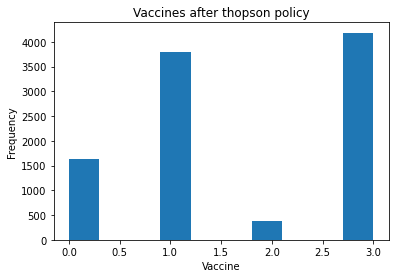

In [89]:
plot_thompson_pol(action_arr)

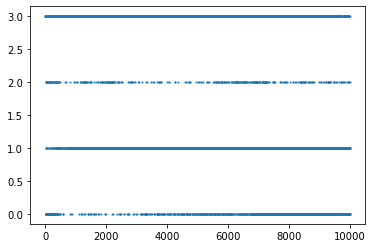

In [23]:
plt.scatter(range(n_population), action_arr, s=1)

In [24]:
print(action_arr.shape)

def plot_fair_pol(actions, data):
    mm = np.where(data[:,11]==1) #male
    ff = np.where(data[:,11]==0) #female

    m_a = np.take(actions, mm)
    m_a = m_a.flatten()

    f_a = np.take(actions, ff)
    f_a = f_a.flatten()

    plt.hist([m_a, f_a],label=['male','female'])
    plt.xlabel('Vaccine')
    plt.ylabel('Frequency')
    plt.title('Vaccines per gender after policy')
    plt.legend(loc='upper right')
    plt.savefig('figures/fair_policy_plot.png')
    plt.show()



(10000,)


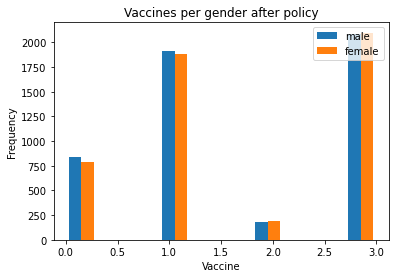

In [25]:
plot_fair_pol(action_arr, X)

In [26]:
def plot_vacc_age(data, actions):
    vacc_0 = np.where(actions==0) #no vaccine
    vacc_1 = np.where(actions==1) #vaccine 1
    vacc_2 = np.where(actions==2) #vaccine 2
    vacc_3 = np.where(actions==3) #vaccine 3
    
    v0_vacc = np.take(data[:,10], vacc_0)
    v0_vacc = v0_vacc.flatten()
    
    v1_vacc = np.take(data[:,10], vacc_1)
    v1_vacc = v1_vacc.flatten()

    v2_vacc = np.take(data[:,10], vacc_2)
    v2_vacc = v2_vacc.flatten()
    
    v3_vacc = np.take(data[:,10], vacc_3)
    v3_vacc = v3_vacc.flatten()


    #f_a = np.take(actions, ff)
    #f_a = f_a.flatten()
    
    plt.hist([v0_vacc, v1_vacc, v2_vacc, v3_vacc],label=['vaccine 0','vaccine 1','vaccine 2','vaccine 3'], bins=20, stacked=True)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Vaccines per age after policy')
    plt.legend(loc='upper right')
    plt.savefig('figures/fair_age_plot.png')
    plt.show()
    

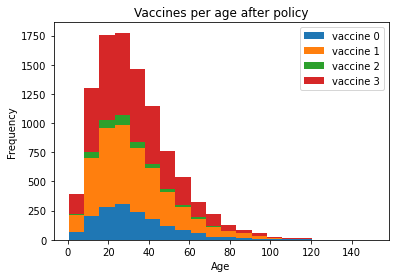

In [27]:
plot_vacc_age(X, action_arr)

In [28]:
def plot_vacc_inc(data, actions):
    vacc_0 = np.where(actions==0) #no vaccine
    vacc_1 = np.where(actions==1) #vaccine 1
    vacc_2 = np.where(actions==2) #vaccine 2
    vacc_3 = np.where(actions==3) #vaccine 3
    
    v0_vacc = np.take(data[:,12], vacc_0)
    v0_vacc = v0_vacc.flatten()
    
    v1_vacc = np.take(data[:,12], vacc_1)
    v1_vacc = v1_vacc.flatten()

    v2_vacc = np.take(data[:,12], vacc_2)
    v2_vacc = v2_vacc.flatten()
    
    v3_vacc = np.take(data[:,12], vacc_3)
    v3_vacc = v3_vacc.flatten()


    #f_a = np.take(actions, ff)
    #f_a = f_a.flatten()
    
    plt.hist([v0_vacc, v1_vacc, v2_vacc, v3_vacc],label=['vaccine 0','vaccine 1','vaccine 2','vaccine 3'], bins=20, stacked=True)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Vaccines per income after policy')
    plt.legend(loc='upper right')
    plt.savefig('figures/fairnes_salary_plot.png')
    plt.show()
    

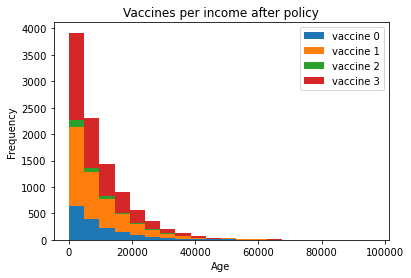

In [29]:
plot_vacc_inc(X, action_arr)

# Thompson with laplace

In [30]:
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_000
n_symptoms = 10

# symptom names for easy reference
from covid.auxilliary import symptom_names

np.random.seed(1)

population = Population(n_genes, n_vaccines, n_treatments)
X = population.generate(n_population)
n_features = X.shape[1]

In [31]:
action_space = np.array([-1,0,1,2])
n_actions = action_space.shape[0]

action_arr_lap = np.zeros(n_population)
symptom_arr_lap = np.zeros((n_population, n_symptoms+1))

In [32]:
policy_l = Naive(n_actions, action_space)
model_l = ThompsonSampling(n_actions)
policy_l.set_model(model)



Initialising policy with  4 actions
A = { [-1  0  1  2] }


In [33]:
print("With a for loop")
# The simplest way to work is to go through every individual in the population
for t in range(n_population):
    a_t = policy_l.get_action()

    # Then you can obtain results for everybody
    y_t = population.vaccinate([t], a_t.reshape((1, 1)))

    new_col = y_t[:,[5,7,8]].sum(axis=1)

    new_col0 = new_col > 0
    new_col01 = new_col0.astype(int)

    new_col01 = np.reshape(new_col01,(1,-1))
    y_t_new = np.hstack((y_t,new_col01))
    
    # Feed the results back in your policy. This allows you to fit the
    # statistical model you have.
    
    policy_l.observe_with_laplace(a_t, y_t_new[:,10])
    #policy.observe(a_t, y_t_new[:,1])
    
    action_arr_lap[t] = a_t
    symptom_arr_lap[t] = y_t_new

With a for loop


In [34]:
alphas_l, betas_l = policy_l.model.get_params()
for i, j in zip(alphas_l, betas_l):
    print(i,j)
print(alphas_l[0]/(alphas_l[0] + betas_l[0]))
print(alphas_l[1]/(alphas_l[1] + betas_l[1]))
print(alphas_l[2]/(alphas_l[2] + betas_l[2]))

142.49802833539425 3757.5019716646075
261.14442632401193 7199.8555736759945
64.81713641433676 1660.1828635856637
243.64451720493534 6678.355482795076
0.03653795598343441
0.035001263412948895
0.03757515154454304


(array([2263.,    0.,    0., 3659.,    0.,    0., 1343.,    0.,    0.,
        2735.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

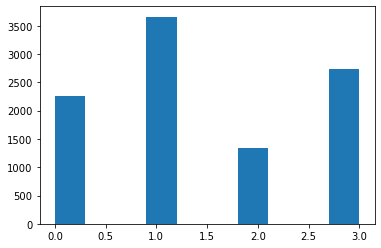

In [35]:
plt.hist(action_arr_lap)

# Utility

In [36]:
utility_laplace = -sum(alphas_l)

In [37]:
utility_laplace

-712.1041082786783

In [38]:
#utility_normal = -sum(alphas)

In [39]:
utility_normal

-348.0

In [40]:
alphas

array([142.49802834, 261.14442632,  64.81713641, 243.6445172 ])

# Experiment design

## historical

In [41]:
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_000
n_symptoms = 10

# symptom names for easy reference
from covid.auxilliary import symptom_names

np.random.seed(1)

population = Population(n_genes, n_vaccines, n_treatments)
X = population.generate(n_population)
n_features = X.shape[1]

In [42]:
new_col = X[:,[5,7,8]].sum(axis=1)
new_col0 = new_col > 0
new_col01 = new_col0.astype(int)
new_col01 = np.reshape(new_col01,(n_population,-1))
X_new = np.hstack((X,new_col01))

hist_pol_utility = -X_new[:,150].sum(axis=0)

In [43]:
hist_pol_utility

-243.0

In [77]:
def plot_hist_policy(data):
    
    v1 = data[:,147].sum(axis=0)
    v2 = data[:,148].sum(axis=0)
    v3 = data[:,149].sum(axis=0)
    v0 = (data[:,[147,148,149]].sum(axis=1)==0).sum()
    plt.bar([0,1,2,3], [v0,v1,v2,v3])
    plt.xlabel('Vaccine')
    plt.ylabel('Frequency')
    plt.title('Vaccines after historical policy')
    plt.savefig('figures/vaccices_historical_policy.png')
    plt.show()

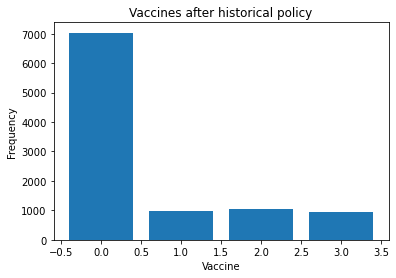

In [78]:
plot_hist_policy(X)

In [45]:
from covid.policy import RandomPolicy

In [46]:
"""
vaccine_policy = RandomPolicy(n_vaccines, action_space) # make sure to add -1 for 'no vaccine'

Y_rand_pol = np.zeros((n_population,n_symptoms))
A_rand_pol = np.zeros(n_population)


print("With a for loop")
# The simplest way to work is to go through every individual in the population
for t in range(n_population):
    #a_t = vaccine_policy.get_action(X[t])
    a_t = vaccine_policy.get_action(X[t])
    print(a_t)
    # Then you can obtain results for everybody
    y_t = population.vaccinate([t], a_t)
    #y_t = population.vaccinate([t], a_t.reshape((1, 1)))
    
    # Feed the results back in your policy. This allows you to fit the
    # statistical model you have.
    #vaccine_policy.observe(X[t], a_t, y_t)
    vaccine_policy.observe(X[t], a_t, y_t)
    
    #print(a_t.shape)
    Y_rand_pol[t] = y_t
    #A_rand_pol[t] = a_t
"""

'\nvaccine_policy = RandomPolicy(n_vaccines, action_space) # make sure to add -1 for \'no vaccine\'\n\nY_rand_pol = np.zeros((n_population,n_symptoms))\nA_rand_pol = np.zeros(n_population)\n\n\nprint("With a for loop")\n# The simplest way to work is to go through every individual in the population\nfor t in range(n_population):\n    #a_t = vaccine_policy.get_action(X[t])\n    a_t = vaccine_policy.get_action(X[t])\n    print(a_t)\n    # Then you can obtain results for everybody\n    y_t = population.vaccinate([t], a_t)\n    #y_t = population.vaccinate([t], a_t.reshape((1, 1)))\n    \n    # Feed the results back in your policy. This allows you to fit the\n    # statistical model you have.\n    #vaccine_policy.observe(X[t], a_t, y_t)\n    vaccine_policy.observe(X[t], a_t, y_t)\n    \n    #print(a_t.shape)\n    Y_rand_pol[t] = y_t\n    #A_rand_pol[t] = a_t\n'

## random

In [47]:
vaccine_policy = RandomPolicy(n_vaccines, action_space)



print("Vaccinate'em all")
# Here you can get an action for everybody in the population
A = vaccine_policy.get_action(X)
A = np.array([int(i) for i in A])
A = A.astype(int)
A = A.reshape((n_population, 1))+1
print(A)
# Then you can obtain results for everybody
Y = population.vaccinate(list(range(n_population)), A)
# Feed the results back in your policy. 
vaccine_policy.observe(X, A, Y)

Initialising policy with  3 actions
A = { [-1  0  1  2] }
Vaccinate'em all
[[0]
 [2]
 [1]
 ...
 [1]
 [2]
 [3]]


In [48]:
print(A)

[[0]
 [2]
 [1]
 ...
 [1]
 [2]
 [3]]


In [71]:
def plot_random_pol(actions):
    
    plt.hist(actions)# label=['0','1','2','3'])
    plt.xlabel('Vaccine')
    plt.ylabel('Frequency')
    plt.title('Vaccines after random policy')
    #plt.legend(loc='upper right')
    plt.savefig('figures/vaccines_random_policy.png')
    plt.show()

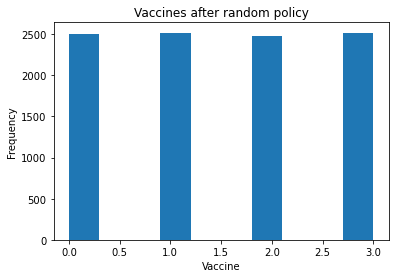

In [72]:
plot_random_pol(A)

In [51]:
print(Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [52]:
new_col = Y[:,[5,7,8]].sum(axis=1)
new_col0 = new_col > 0
new_col01 = new_col0.astype(int)
new_col01 = np.reshape(new_col01,(n_population,-1))
Y_new = np.hstack((Y,new_col01))
rand_pol_utility = -Y_new[:,10].sum(axis=0)

In [53]:
rand_pol_utility

-344.0

## 